# Vibration Compensation

#### Problem:  Vehicle platform oscillates at frequency higher than period of LIDAR scan

At the same time, we need the full convex hull of a LIDAR scan to "guarentee" convergence


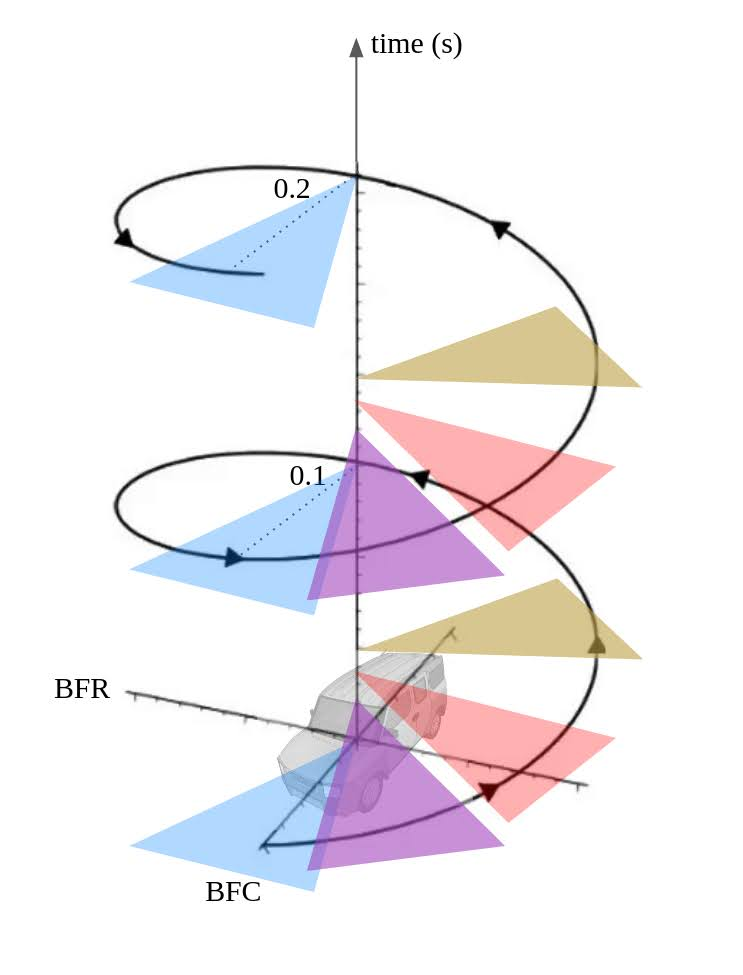

### Goal: find registrations that best align slices of matching colors

### Use ICET to register sequential "timed" slices, apply smoothing operation to constrain neighboring angular slices 

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


2023-03-01 21:00:29.622811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:00:29.719831: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 21:00:30.331955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-01 21:00:30.332016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-01 21:00:31.395734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:00:31.396530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 21:00:31.396710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 21:00:31.396837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


### Import dataset

In [2]:
# #big hill and church:
drive = "20200721_144638_part36_1956_2229"

# # straight road, narrow with pedestrians and shops 
# drive = "20200617_191627_part12_1614_1842"

#suburban neighborhood, trees, houses and parked cars
# drive = "20200706_161206_part22_670_950"

In [3]:
dataset_path = "/media/derm/06EF-127D3/leddartech/" + drive
config_path = "/media/derm/06EF-127D3/leddartech/" + drive + "/platform.yml"
pf = Platform(dataset_path, config_path)

idx = 220 #turn
skips = 1
undistort = False
# undistort = True

data1 = pf['ouster64_bfc_xyzit'][idx].get_point_cloud(undistort = undistort)
lidar_time1 = pf['ouster64_bfc_xyzit'][idx].get_field('t')
lidar_time1 = lidar_time1 - lidar_time1[0]
lidar_time1 = np.asarray(lidar_time1 / max(lidar_time1))
data1 = np.asarray(data1.tolist())[:,:3]

data2 = pf['ouster64_bfc_xyzit'][idx+skips].get_point_cloud(undistort = undistort)
lidar_time2 = pf['ouster64_bfc_xyzit'][idx+skips].get_field('t')
lidar_time2 = lidar_time2 - lidar_time2[0]
lidar_time2 = np.asarray(lidar_time2 / max(lidar_time2))
data2 = np.asarray(data2.tolist())[:,:3]

Loading sensors: 100%|████████████████████████████| 9/9 [00:00<00:00, 64.30it/s]


# Get (distorted) gross transform by applying ICET to entire point clouds

In [4]:
binsize = 50
it = ICET(cloud1 = data1, cloud2 = data2, fid = binsize, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, cheat = x0)
ViewInteractiveWidget(it.plt.window)

2023-03-01 21:00:44.847546: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,
2023-03-01 21:00:47.102590: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-01 21:00:47.161081: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x75d7c70



 estimated solution vector X: 
 tf.Tensor(
[ 3.5562643e-01  4.1323118e-02  4.6602474e-04  1.7247448e-04
 -2.6226556e-03  1.0908700e-02], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [ ]:
#now just look at a few azimutal bins at a time
horizontal_bins_per_slice = 5
num_azim_bins = binsize // horizontal_bins_per_slice
# num_azim_bins = 20

plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

stepsize = 2*np.pi / num_azim_bins
lower_bound = -np.pi
upper_bound = lower_bound + stepsize
# for a in range(num_azim_bins):
for a in range(num_azim_bins - 5): #debug
#     print("\n lower_bound:", lower_bound,"upper_bound:", upper_bound)

    S1 = it.cloud1_tensor_spherical[it.cloud1_tensor_spherical[:,1] > lower_bound]
    S1 = S1[S1[:,1] < upper_bound]
    S1 = it.s2c(S1)

    S2 = it.cloud2_tensor_spherical[it.cloud2_tensor_spherical[:,1] > lower_bound]
    S2 = S2[S2[:,1] < upper_bound]
    S2 = it.s2c(S2)
    disp.append(Points(S2, c = (np.random.rand(), np.random.rand(), np.random.rand())))
    
    lower_bound = upper_bound
    upper_bound += stepsize

plt1.show(disp, "Fig LedderTech")
ViewInteractiveWidget(plt1.window)


In [ ]:
# plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
# disp = []
# disp.append(Points(S1, c = 'r'))
# disp.append(Points(S2, c = 'b'))
# plt1.show(disp, "Fig LedderTech")
# ViewInteractiveWidget(plt1.window)

#TODO: should I use cloud2_OG or transformed cloud 2 output by ICET1??

#run ICET again, just on the local slice
# it2 = ICET(cloud1 = S1, cloud2 = S2, fid = binsize, niter = 10, 
#            draw = True, group = 2, RM = False, DNN_filter = False)

#check that there are enough occupied voxles to trust registration
# ncells = it2.npts2
#TODO: get the number of indiecs that correspond to nonzero values in both it2.npts1 and it2.npts2
print(it2.npts1)
print(it2.npts2)

# ViewInteractiveWidget(it2.plt.window)

### Get true transform using EgomotionProvider()

In [ ]:
provider = pf.egomotion_provider
#for entire trajectory
time_range = provider.get_timestamps()
subsample = 1
traj1 = provider.get_trajectory(time_range, subsampling = subsample) #subsampling is inverted (100 is LOWER resolution)
# print(np.shape(traj1))
time_range = time_range[::subsample] #need to reduce time range if we subsample
# print(np.shape(time_range))

# fig,ax = plt.subplots()
# ax.set_aspect("equal")
# ax.plot(traj1[:,0,-1], traj1[:,1,-1])

T = np.eye(4)
x_hist_gt = np.zeros([len(traj1), 6])
for idx_i, i in enumerate(traj1):
#     print(i)
    T = T * i
#     print(T)
    x_hist_gt[idx_i,0] = T[0,-1] #E
    x_hist_gt[idx_i,1] = T[1,-1] #N
    x_hist_gt[idx_i,2] = T[2,-1] #U
    #get euler angles from rotation matrix
    euls = R.from_matrix(i[:3,:3]).as_euler('xyz', degrees=False)
    x_hist_gt[idx_i,3:] = euls

In [ ]:
#get transform between two frames being considered
# t = pf['ouster64_bfc_xyzit'][idx].get_field('t')
time_range_test = provider.get_timestamps()
print(len(time_range_test))
# traj_local = provider.get_trajectory(t, subsampling = subsample)


## plot results against ground truth

In [ ]:
fig, ax = plt.subplots(2,1)

# x_hist = np.loadtxt("leddartech_ICET_estimates.txt")
# pred_stds = np.loadtxt("leddartech_ICET_pred_stds.txt")

x_hist = np.loadtxt("results/leddartech_ICET_estimates_v2.txt")
pred_stds = np.loadtxt("results/leddartech_ICET_pred_stds_v2.txt") 
x_hist_NDT = np.loadtxt("results/leddartech_NDT_estimates.txt")

#get timestamp of first range return in LIDAR trajectory
ts_lidar = np.zeros(len(x_hist))
for c in range(len(x_hist)):
    ts_lidar[c] = pf['ouster64_bfc_xyzit'][c].get_field('t')[-1]

print(pred_stds[0])
ax[0].plot(ts_lidar, x_hist[:,0], label = 'ICET (full frames)')
# ax[0].plot(ts_lidar, x_hist_NDT[:,0], label = 'NDT')
ax[0].fill_between(ts_lidar, x_hist[:,0]+ 2*pred_stds[:,0], x_hist[:,0] - 2*pred_stds[:,0], 
                 color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
ax[0].plot(time_range[:-1], (5/subsample)*np.sqrt(np.diff(traj1[:,0,-1])**2 + np.diff(traj1[:,1,-1])**2),'k-', label = 'ground truth' ) #fwd
ax[0].set_title("forward translation")
ax[0].legend(loc = 'best')

ax[1].plot(time_range[1:], (5/subsample)*np.diff(x_hist_gt[:,-1]), 'k-', label = 'ground truth') #yaw
ax[1].fill_between(ts_lidar, x_hist[:,-1]+ 2*pred_stds[:,-1], x_hist[:,-1] - 2*pred_stds[:,-1], 
                 color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
ax[1].plot(ts_lidar, x_hist[:,5], label = 'ICET (full frames)')
ax[1].set_title("yaw")
ax[1].legend(loc = 'best')